In [0]:
import numpy as np
import os 
import argparse
import cmath
import random
from numpy.linalg import norm
from numpy.linalg import inv
from numpy import matmul, transpose
import matplotlib.pyplot as plt
j = complex(0,1)

Y_SIZE = 512
H_SIZE = 32
SIG1 = np.sqrt(0.001)
SIG2 = np.sqrt(0.1)
LAMBDA = 0.2
M = 100 # Number of trials

In [0]:
# Constructing X and F

F = np.empty((Y_SIZE,H_SIZE),dtype=np.csingle) 
for i in range(F.shape[0]):
    for k in range(F.shape[1]):
        F[i][k] = cmath.exp(1j*(2*cmath.pi*i*k/512))        

# Constructing h
def get_x_h():
    x = np.random.choice([1+1j,1-1j,-1+1j,-1-1j],size=Y_SIZE)
    X = np.diag(x,k=0)
    p = np.asarray([np.exp(-1*(LAMBDA)*i) for i in range(H_SIZE)])
    p = p/norm(p)
    a = np.random.normal(scale=0.5,size=H_SIZE)
    b = np.random.normal(scale=0.5,size=H_SIZE)
    h = np.multiply(p,a+b*j).reshape(-1,1)
    return X,h

# Calculate A, where A = XF and y = XFh + n
X,h = get_x_h()
A = matmul(X,F)

In [0]:
def pinv(A, alpha=0):
    Ah = np.asmatrix(A).getH()
    return  matmul(inv(matmul(Ah,A)+alpha*np.eye(np.shape(Ah)[0])),Ah)

def squared_error_theo(design_matrix, vector, alpha=0):
    projection_matrix = np.matmul(design_matrix, pinv(design_matrix, alpha))
    I = np.eye(np.shape(projection_matrix)[0])
    projection_matrix_perp = I - projection_matrix
    return norm(np.matmul(projection_matrix_perp, vector))**2

In [0]:
def normalized_difference(y_original, y_hat):
    return norm(y_original-y_hat)/norm(y_original)

def squared_error(vector1, vector2):
    return norm(vector1-vector2)**2


In [5]:
# Q1
def estimate_vanilla_h(A,h,sig=SIG1, rse=False):
    n = np.random.normal(loc=0, scale=sig,size=(Y_SIZE,2)).view(np.complex128)
    y = matmul(A,h) + n
    h_hat = matmul(pinv(A), y)
    d = normalized_difference(h,h_hat)
    y_hat = np.matmul(A, h_hat)
    error_theoretical = squared_error_theo(A, y)
    error_calculated = squared_error(y, y_hat)
    if rse:
        return h_hat,d, error_theoretical, error_calculated
    else:
        return h_hat,d

# Averaging over M trials
def question1(M=M,sig=SIG1):
    all_h = []
    all_h_hat = []
    error_theo = []
    error_calc = []
    for i in range(M):
        X,h = get_x_h()
        A = matmul(X,F)
        h_hat, d, error_theo_, error_calc_ = estimate_vanilla_h(A,h,sig,True)
        error_theo.append(error_theo_)
        error_calc.append(error_calc_)
        all_h.append(h)
        all_h_hat.append(h_hat)
    print(" MSE Theoretical :", np.mean(error_theo))
    print(" MSE Calculated :", np.mean(error_calc))
    return all_h, all_h_hat

all_hq1, all_h_hatq1 = question1(M,sig=SIG1)
mean_h = sum(all_hq1)/M
mean_h_hat = sum(all_h_hatq1)/M

 MSE Theoretical : 0.9559240571402664
 MSE Calculated : 0.9559240571402665


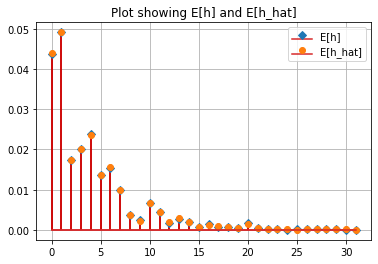

<Figure size 2880x1440 with 0 Axes>

In [6]:
def plot_h(h,h_hat, label='h', label_1='h_hat', title=None):
    m = len(h)
    norm_h = [norm(a) for a in h]
    norm_h_hat = [norm(a) for a in h_hat]
    plt.stem(np.arange(0,m),norm_h,linefmt='k', markerfmt='D',label=label, use_line_collection=True)
    plt.stem(np.arange(0,m),norm_h_hat,linefmt='r', markerfmt='o',label=label_1,use_line_collection=True)
    plt.legend(loc='upper right')
    if title is None:
      plt.title(f"Plot showing {label} and {label_1}")
    else:
      plt.title(title)
    plt.grid(True)
    plt.figure(figsize=(40,20))
    plt.show()  

plot_h(mean_h,mean_h_hat,label="E[h]",label_1="E[h_hat]")

 MSE Theoretical : 95.3558413206611
 MSE Calculated : 95.3558413206611


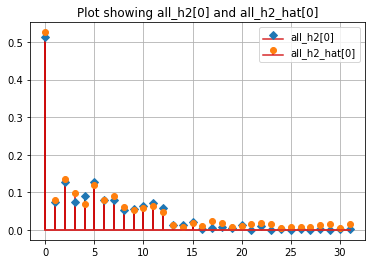

<Figure size 2880x1440 with 0 Axes>

In [7]:
all_h2,all_h_hat2 = question1(sig=SIG2)
plot_h(all_h2[0],all_h_hat2[0], label="all_h2[0]", label_1="all_h2_hat[0]")

 MSE Theoretical : 0.9521593606672343
 MSE Calculated : 1.01500554460821


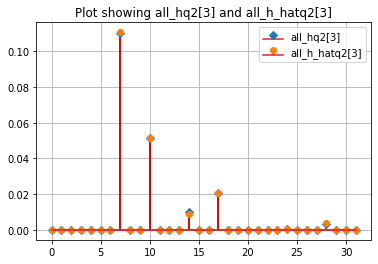

<Figure size 2880x1440 with 0 Axes>

In [8]:
# Q2
def estimate_sparse_h(A=A,h=h,sig=SIG1,sparsity_points=None,rse = False,alpha=0):
    h_sparse = h.copy()
    if sparsity_points is None:
        sparsity_points = [i for i in random.sample(range(0,H_SIZE),H_SIZE-6)]
    for i in sparsity_points:
        h_sparse[i] = 0
    n = np.random.normal(loc=0, scale=sig,size=(Y_SIZE,2)).view(np.complex128)
    y_sparse = np.matmul(A,h_sparse) + n
    constraints_matrix = np.zeros((len(sparsity_points), H_SIZE))
    for i in range(len(sparsity_points)):
        constraints_matrix[i,sparsity_points[i]]=1
    h_hat_unconstrained = matmul(pinv(A,alpha=alpha), y_sparse)
    Ah = np.asmatrix(A).getH()
    
    lambda_ = matmul(2*inv(matmul(matmul(constraints_matrix, inv(matmul(Ah, A)+alpha*np.eye(np.shape(Ah)[0]))), \
                                  transpose(constraints_matrix))), matmul(constraints_matrix, h_hat_unconstrained))
    h_hat_constrained = h_hat_unconstrained - 0.5*matmul(matmul(inv(matmul(Ah,A)+alpha*np.eye(np.shape(Ah)[0])), \
                                                                transpose(constraints_matrix)), lambda_)
    d_constrained = normalized_difference(h_sparse,h_hat_constrained)

    y_hat = A@h_sparse
    error_theoretical = squared_error_theo(A, y_sparse)
    error_calculated = squared_error(y_sparse, y_hat)
    
    if rse:
        return h_hat_constrained,d_constrained, error_theoretical, error_calculated
    else:
        return h_hat_constrained,d_constrained

def question2(M=M,sig=SIG1,sparsity_points=None):
    all_h = []
    all_h_hat = []
    error_theo = []
    error_calc = []
    for i in range(M):
        X,h = get_x_h()
        if not sparsity_points:
            sparsity_points = [i for i in random.sample(range(0,H_SIZE),H_SIZE-6)]
        h[sparsity_points] = 0
        A = matmul(X,F)
        h_hat,d, error_theo_, error_calc_= estimate_sparse_h(A,h,sig,sparsity_points,rse=True)
        all_h.append(h)
        all_h_hat.append(h_hat)
        error_theo.append(error_theo_)
        error_calc.append(error_calc_)
    print(" MSE Theoretical :", np.mean(error_theo))
    print(" MSE Calculated :", np.mean(error_calc))
    return all_h, all_h_hat

all_hq2,all_h_hatq2 = question2(M,SIG1)
plot_h(all_hq2[3],all_h_hatq2[3],"all_hq2[3]","all_h_hatq2[3]")

 MSE Theoretical : 95.51135435930719
 MSE Calculated : 101.75727090594893


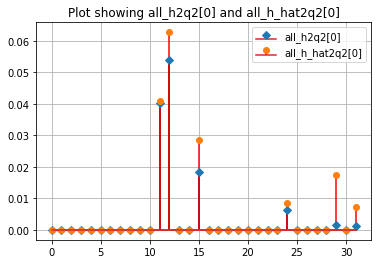

<Figure size 2880x1440 with 0 Axes>

In [9]:
all_h2q2,all_h_hat2q2 = question2(M,SIG2)
plot_h(all_h2q2[0],all_h_hat2q2[0],"all_h2q2[0]","all_h_hat2q2[0]")

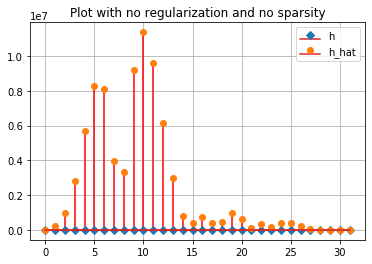

<Figure size 2880x1440 with 0 Axes>

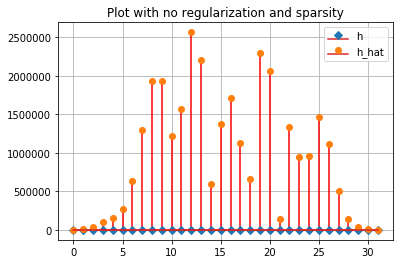

<Figure size 2880x1440 with 0 Axes>

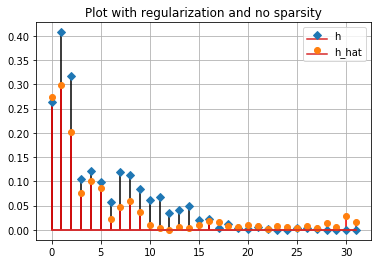

<Figure size 2880x1440 with 0 Axes>

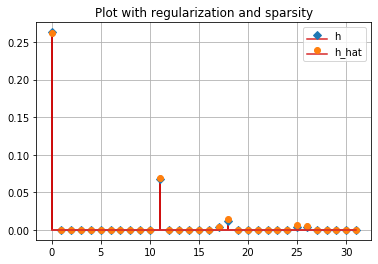

<Figure size 2880x1440 with 0 Axes>

In [10]:
# Q3a
def estimate_guard_h_no_reg(A,h,h_,sig,sparsity_points,rse=False):
    # h_ is sparse h generated
    if rse:
        h_vanilla,d_vanilla,et_v, ec_v = estimate_vanilla_h(A=A,h=h,sig=sig, rse=True)
        h_sparse,d_sparse, et_s, ec_s = estimate_sparse_h(A=A,h=h_,sig=sig,sparsity_points=sparsity_points, rse=True)
        return h_vanilla, h_sparse, et_v, ec_v, et_s, ec_s 
    else:
        h_vanilla,d_vanilla = estimate_vanilla_h(A=A,h=h,sig=sig)
        h_sparse,d_sparse = estimate_sparse_h(A=A,h=h_,sig=sig,sparsity_points=sparsity_points)
        return h_vanilla, h_sparse, 0,0,0,0
        
sparse =  [i for i in random.sample(range(0,H_SIZE),H_SIZE-6)]
h_ = h.copy()
h_[sparse] = 0
X_ = X.copy()
X_[:180] = 0
X_[-180:] = 0
A = matmul(X_,F)

h_vanilla,h_sparse, et_v, ec_v, et_s, ec_s = estimate_guard_h_no_reg(A,h,h_,SIG1,sparse, rse=True)

# Q3b
def estimate_guard_h_reg(A=A,h=h,h_=h_,sparsity_points=None,alpha=1,sig=SIG1):
    
    h_sparse,d_sparse, et_s, ec_s = estimate_sparse_h(A=A,h=h_,sig=sig,sparsity_points=sparsity_points, rse=True,alpha=alpha)
    n = np.random.normal(loc=0, scale=sig,size=(Y_SIZE,2)).view(np.complex128)
    y_ = matmul(A,h) + n
    y_sparse = matmul(A,h_) +n 

    h_hat_ = matmul(pinv(A, alpha), y_)
    d_ = normalized_difference(h,h_hat_)
    y_hat = A@h_hat_
    error_theoretical = squared_error_theo(A, y_,alpha=alpha)
    error_calculated = squared_error(y_, y_hat)
    return h_hat_,h_sparse, error_theoretical, error_calculated, et_s, ec_s

h_hat = estimate_guard_h_reg(A,h,alpha=0.01,sig=SIG1)
def question3_no_reg(M,sig=SIG1,sparsity_points=None):
    all_h = np.zeros((4,M,H_SIZE), dtype=np.complex128)
    for i in range(M):
        X,h = get_x_h()
        X[:180] = 0
        X[-180:] = 0
        A = matmul(X,F)
        h_ = h.copy()
        if not sparsity_points:
            sparsity_points = [i for i in random.sample(range(0,H_SIZE),H_SIZE-6)]
        h_[sparsity_points] = 0
        h_vanilla,h_sparse, et_v, ec_v, et_s, ec_s = estimate_guard_h_no_reg(A,h,h_,sig,sparsity_points,True)
        all_h[0,i]=h.reshape(H_SIZE)
        all_h[1,i]=h_vanilla.reshape(H_SIZE)
        all_h[2,i]=h_.reshape(H_SIZE)
        all_h[3,i]=h_sparse.reshape(H_SIZE)

    return all_h

def question3_reg(M,alpha=10,sparsity_points=None, sig=SIG1):
    all_h = np.zeros((4,M,H_SIZE), dtype=np.complex128) # h, h_hat, h_sparse, h_hat_sparse
    for i in range(1):
        X,h = get_x_h()
        h_ = h.copy()
        X[:180] = 0
        X[-180:] = 0
        A = matmul(X,F)
        if not sparsity_points:
            sparsity_points = [i for i in random.sample(range(0,H_SIZE),H_SIZE-6)]
        h_[sparsity_points] = 0
        h_vanilla,h_sparse, et_v, ec_v, et_s, ec_s = estimate_guard_h_reg(A,h,h_,sparsity_points=sparsity_points,sig=sig,alpha=alpha)
        all_h[0,i]=h.reshape(H_SIZE)
        all_h[1,i]=h_vanilla.reshape(H_SIZE)
        all_h[2,i]=h_.reshape(H_SIZE)
        all_h[3,i]=h_sparse.reshape(H_SIZE)

    return all_h

all_h = question3_no_reg(M=M,sig=SIG1)
all_h_reg = question3_reg(M=M,alpha=0.1,sig=SIG1)
plot_h(all_h[0][0],all_h[1][0],title="Plot with no regularization and no sparsity" )
plot_h(all_h[2][0],all_h[3][0],title="Plot with no regularization and sparsity" )
plot_h(all_h_reg[0][0],all_h_reg[1][0],title="Plot with regularization and no sparsity" )
plot_h(all_h_reg[2][0],all_h_reg[3][0],title="Plot with regularization and sparsity" )

In [11]:
# Q4

# Building constraints matrix
number_of_constraints = 3
constraints_matrix = np.zeros((number_of_constraints, H_SIZE))
constraints_matrix[0,0]=1
constraints_matrix[0,1]=-1
constraints_matrix[1,2]=1
constraints_matrix[1,3]=-1
constraints_matrix[2,4]=1
constraints_matrix[2,5]=-1

def estimate_constrained_h(A=A,h=h,sig=SIG1, alpha=0):
    h_constrained = h
    h_constrained[0] = h_constrained[1]
    h_constrained[2] = h_constrained[3]
    h_constrained[4] = h_constrained[5]
    
    n = np.random.normal(loc=0, scale=sig,size=(Y_SIZE,2)).view(np.complex128)
    y_constrained = np.matmul(A,h_constrained) + n

    h_hat_unconstrained = matmul(pinv(A), y_constrained)
    Ah = np.asmatrix(A).getH()
    lambda_ = matmul(2*inv(matmul(matmul(constraints_matrix, inv(matmul(Ah, A)+alpha*np.eye(np.shape(Ah)[0]))),\
                                  transpose(constraints_matrix))), matmul(constraints_matrix, h_hat_unconstrained))
    h_hat_constrained = h_hat_unconstrained - 0.5*matmul(matmul(inv(matmul(Ah,A)+alpha*np.eye(np.shape(Ah)[0])),\
                                                                transpose(constraints_matrix)), lambda_)
    d_constrained = normalized_difference(h_constrained,h_hat_constrained)
    y_hat = A@h_hat_constrained
    error_theoretical = squared_error_theo(A, y_constrained,alpha=0)
    error_calculated = squared_error(y_constrained, y_hat)
    return h_hat_constrained,error_theoretical,error_calculated

def question4(M=M,sig=SIG1):
    all_h = []
    all_h_hat = []
    error_theo = 0
    error_calc = 0
    for i in range(M):
        X,h = get_x_h()
        A = matmul(X,F)
        h_hat, error_theo_, error_calc_= estimate_constrained_h(A,h,sig)
        all_h.append(h)
        all_h_hat.append(h_hat)
        error_theo += error_theo_
        error_calc += error_calc_
    print(" MSE Theoretical :", error_theo/M)
    print(" MSE Calculated :", error_calc/M)
    return all_h,all_h_hat
    
a= question4(M=10,sig=SIG1)

 MSE Theoretical : 0.9603589423761276
 MSE Calculated : 0.9664940211570082


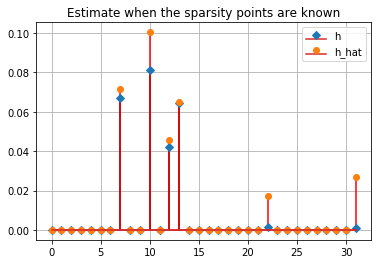

<Figure size 2880x1440 with 0 Axes>

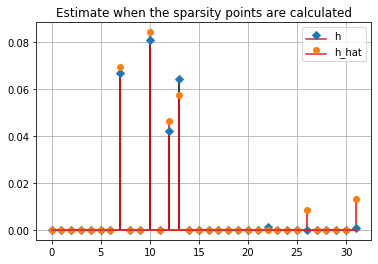

<Figure size 2880x1440 with 0 Axes>

In [12]:
# Q5
def question5(A,h,alpha=0,sig=SIG1):
    Somp = []
    n = np.random.normal(loc=0, scale=sig,size=(Y_SIZE,2)).view(np.complex128)
    y = matmul(A,h) +n
    r = y.copy()
    ko = 6
    Ah = np.asmatrix(A).getH()
    for k in range(ko):
        t_ = np.matmul(Ah,r)
        t = np.argmax(np.abs(np.matmul(Ah,r)))
        Somp.append(int(t))
        p = np.matmul(A[:,Somp],pinv(A[:,Somp],alpha))
        r = np.matmul((np.eye(Y_SIZE) - p),y)
    sparsity_points = [x for x in range(H_SIZE) if x not in Somp]
    return sparsity_points

A_ = X@F
X,h =get_x_h()
sparsity_points_known = [i for i in random.sample(range(0,H_SIZE),H_SIZE-6)]
h_ori = h.copy()
h[sparsity_points_known] = 0
sparsity_points_calculated = question5(A_,h,sig=SIG1)
h_known,d = estimate_sparse_h(A=A_,h=h_ori,sig=SIG2,sparsity_points=sparsity_points_known, alpha=1)
h_calculated, d_ = estimate_sparse_h(A=A_,h=h,sig=SIG2,sparsity_points=sparsity_points_calculated, alpha=1)
plot_h(h, h_known, title="Estimate when the sparsity points are known")
plot_h(h, h_calculated, title="Estimate when the sparsity points are calculated")